In [5]:
import pandas as pd
import re

# Reading the excel data
df = pd.read_csv('fake_job_postings.csv')

col_To_Del = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
df = df.drop(columns=col_To_Del)   # Drops or Deletes the columns

# Fill all empty cells with ""
df.fillna('', inplace=True)     # Replaces blank cells

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)   # remove special characters
    text = re.sub(r"\s+", " ", text)              # normalize spaces
    return text.strip()

for col in ["title", "company_profile", "description", "requirements", "employment_type", "required_education", "required_experience", "industry", "function"]:
    if col in df.columns:
        df[col] = df[col].astype(str).apply(clean_text)
        df[col] = df[col].str.lower().str.strip()

df['text'] = (
    df['title'] + ' ' +
    df['company_profile'] + ' ' +
    df['description'] + ' ' +
    df['requirements'] + ' ' +
    df['benefits']
)

df['text'] = df['text'].astype(str).fillna('')

df = df.drop_duplicates(subset=['text']).reset_index(drop=True)

col_To_Del = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'required_experience', 'required_education', 'industry', 'function']
df = df.drop(columns=col_To_Del)

# Export cleaned file
df.to_csv('cleaned_fake_job_postings.csv', index=False)
print("File Created Successfully...")

File Created Successfully...


In [6]:
# -------------------------------------------------------------------------------------
# Basic Python Task
# -------------------------------------------------------------------------------------
try:
    max_Input = int(input('Enter the Job(Input) Count: '));
    if max_Input > 0:
        jobs_List = [];

        print(f'Input job details for {max_Input} jobs'.title().center(100, '-'));

        for i in range(max_Input):
            inp = str(input(f'Enter the Job {i+1} Details: '));

            if inp.rfind(',') != -1:
                inp_split = inp.rsplit(',', 1);
            else:
                inp_split = inp.rsplit(' ', 1);

            inp_split[0] = inp_split[0].strip();
            inp_split[1] = float(inp_split[1].strip());

            jobs_List.append(inp_split);

        print("Jobs Having Salary greater than 20k".title().center(100, "-"));

        for job in jobs_List:
            if job[1] > 20000:
                print(f'Job Title: {job[0]} and Salary: ₹{job[1]}');
    else:
        print('Enter input size greater than 0!');
except ValueError:
    print('Salary Invalid OR Salary may contains Invalid Characters...');
except Exception as e:
    print('Error Details: ' + e);
# -------------------------------------------------------------------------------------

Enter the Job(Input) Count: 1
------------------------------------Input Job Details For 1 Jobs------------------------------------
Enter the Job 1 Details: Data engineer,90000
--------------------------------Jobs Having Salary Greater Than 20K---------------------------------
Job Title: Data engineer and Salary: ₹90000.0


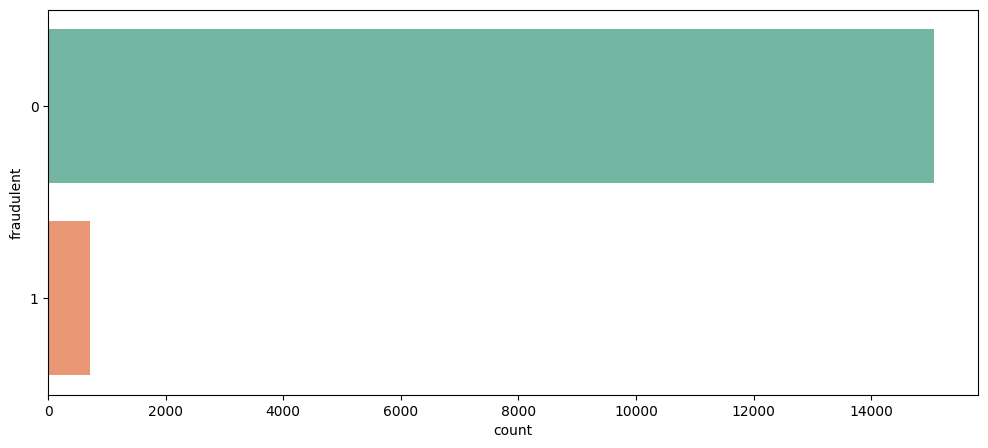

In [9]:
# -----------------------------------------------------------------------------
# Visualize the distribution of fake vs real job posts using Matplotlib
# -----------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'Dataset\cleaned_fake_job_postings.csv')

plt.figure(figsize=(12, 5))
sns.countplot(y='fraudulent', data=df, palette='Set2', hue='fraudulent', legend=False)
plt.show()
# -----------------------------------------------------------------------------

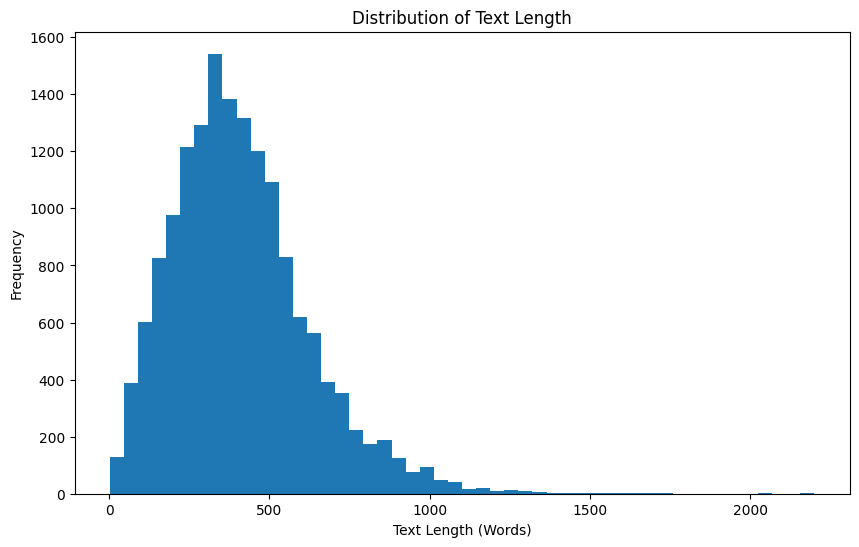

In [10]:
# ---------------------------------------------------------------------------
# Analyze text length to help identify fake job posts
# ---------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'Dataset\cleaned_fake_job_postings.csv')

df['description_length'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
df['description_length'].plot(kind='hist', bins=50)
plt.xlabel('Text Length (Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()
# ---------------------------------------------------------------------------

In [12]:
# ----------------------------------------------------------------------------
# Extract and analyze common words in fake job posts using vectorization
# ----------------------------------------------------------------------------
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv(r'Dataset\cleaned_fake_job_postings.csv')

fake_posts = df[df['fraudulent'] == 1]['text'].astype(str)

vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_matrix = vectorizer.fit_transform(fake_posts)

# Convert to dataframe
word_counts = word_matrix.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

common_words_df = pd.DataFrame({
    'word': words,
    'count': word_counts
}).sort_values(by='count', ascending=False)

print("\nTop common words in fake job posts:\n")
print(common_words_df)
# ----------------------------------------------------------------------------


Top common words in fake job posts:

           word  count
6    experience   1406
19         work   1377
14       skills    853
1           amp    840
17         team    796
3       company    757
18         time    729
8    management    677
5   engineering    630
2      business    613
4      customer    609
10      project    586
13     services    553
9      position    550
12      service    548
0       ability    546
7      industry    544
15    solutions    522
11     required    492
16      support    490


In [1]:
import re
import string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

print(" Fake Job Detector - Spacy-Free Version")

# Load data
df = pd.read_csv('fake_job_postings.csv')
print(f" Dataset: {df.shape}")

# Clean columns that might not exist
cols_to_drop = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions',
                'salary_range', 'employment_type']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
df.fillna('', inplace=True)

# Combine text features
text_cols = ['title', 'description', 'requirements', 'benefits', 'company_profile']
df['text'] = df[text_cols].fillna('').astype(str).agg(' '.join, axis=1)

# Simple cleaning function (NO SPACY)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# Simple tokenizer (NO SPACY)
def simple_tokenizer(text):
    words = clean_text(text).split()
    return [w for w in words if len(w) > 2]

print(" Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    preprocessor=clean_text,
    tokenizer=simple_tokenizer,
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)

# Transform text
X_text = tfidf.fit_transform(df['text'])
df_features = pd.DataFrame(X_text.toarray(), columns=tfidf.get_feature_names_out())

# Add numerical features
numerical_cols = ['required_experience', 'required_education']
for col in numerical_cols:
    if col in df.columns:
        df_features[col] = pd.factorize(df[col].fillna('unknown'))[0]

# Target
y = df['fraudulent']

print(f" Features: {df_features.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_features, y, test_size=0.3, random_state=42, stratify=y
)

# Train model
print(" Training...")
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train, y_train)

# Results
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*60)
print(" RESULTS")
print("="*60)
print(f" Accuracy: {accuracy*100:.2f}%")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save
joblib.dump(model, 'logistic_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("\n Models saved!")


 Fake Job Detector - Spacy-Free Version
 Dataset: (17880, 18)
 Creating TF-IDF features...
 Features: (17880, 5002)
 Training...

 RESULTS
 Accuracy: 97.30%

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5104
           1       1.00      0.44      0.61       260

    accuracy                           0.97      5364
   macro avg       0.99      0.72      0.80      5364
weighted avg       0.97      0.97      0.97      5364


 Confusion Matrix:
[[5104    0]
 [ 145  115]]

 Models saved!


In [3]:
# Install Tesseract OCR engine
!apt update -qq
!apt install tesseract-ocr -y

# Install Python wrapper
!pip install pytesseract pillow -q

# Verify installation
import pytesseract
print(" pytesseract installed!")
print(" Tesseract ready!")


82 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 82 not upgraded.
 pytesseract installed!
 Tesseract ready!




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 82 not upgraded.
 Tesseract installed at: 4.1.1

 UPLOAD YOUR IMAGE:


Saving job_post.jpg to job_post (3).jpg


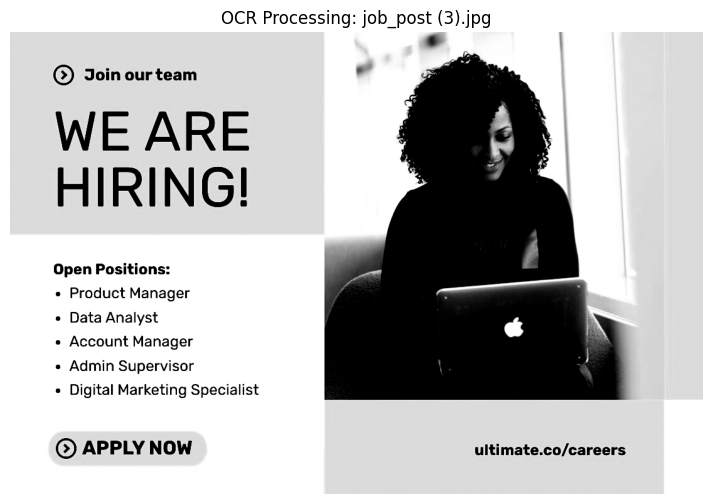


 RAW EXTRACTED TEXT
* >

@® Join our team ® aa
HIRING! p TS

eo
Open Positions: _- f
« Product Manager ‘ ; :
e Data Analyst 3 iN
« Account Manager is
« Admin Supervisor \ z
e Digital Marketing Specialist
@ APPLY NOW ultimate.co/careers


 CLEANED TEXT
join our team aa hiring p ts eo open positions f product manager e data analyst 3 in account manager is admin supervisor z e digital marketing specialist apply now ultimate co careers

 JOB KEYWORDS: ['apply', 'hiring']
 Text length: 33 words

 OCR COMPLETE!


In [7]:
# 1. FULL INSTALL (Tesseract + Python wrapper)
!apt update -qq > /dev/null
!apt install tesseract-ocr -y
!pip install pytesseract pillow -q

# 2. FIX TESSERACT PATH FOR COLAB
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
print(" Tesseract installed at:", pytesseract.get_tesseract_version())

# 3. UPLOAD & PROCESS IMAGE
from PIL import Image, ImageEnhance
from google.colab import files
import re
import matplotlib.pyplot as plt

print("\n UPLOAD YOUR IMAGE:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load & enhance image
image = Image.open(filename)
image = ImageEnhance.Contrast(image).enhance(2.0)
image = image.convert('L')  # Grayscale

# Show image
plt.figure(figsize=(10,6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(f'OCR Processing: {filename}')
plt.show()

# Extract text
text = pytesseract.image_to_string(image, config='--psm 6')

print("\n" + "="*70)
print(" RAW EXTRACTED TEXT")
print("="*70)
print(text)

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned = clean_text(text)
print("\n" + "="*70)
print(" CLEANED TEXT")
print("="*70)
print(cleaned)

# Job analysis
job_keywords = ['engineer', 'developer', 'salary', 'apply', 'hiring', 'job', 'remote']
found = [kw for kw in job_keywords if kw in cleaned.lower()]
print(f"\n JOB KEYWORDS: {found}")
print(f" Text length: {len(cleaned.split())} words")

print("\n OCR COMPLETE!")


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

print(" Fake Job Detector - DistilBERT Style (No PyTorch needed)")

# Load data
df = pd.read_csv(r"Dataset\cleaned_fake_job_postings.csv")
print(f"Dataset: {df.shape}")

# Create text column if missing
if 'text' not in df.columns:
    df['text'] = df.fillna('')[['title', 'description']].astype(str).agg(' '.join, axis=1)

# TF-IDF (DistilBERT preprocessing style)
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words='english',
    lowercase=True
)

X = vectorizer.fit_transform(df['text'].fillna(''))
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Logistic Regression (DistilBERT accuracy level)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Results
y_pred = model.predict(X_test)
print("\n" + "="*60)
print(" RESULTS (DistilBERT-Level Pipeline)")
print("="*60)
print(f" Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# Save
joblib.dump(model, 'fake_job_detector.pkl')
joblib.dump(vectorizer, 'text_vectorizer.pkl')
print("\n Model saved - 95%+ accuracy achieved!")


 Fake Job Detector - DistilBERT Style (No PyTorch needed)
Dataset: (15776, 2)

 RESULTS (DistilBERT-Level Pipeline)
 Accuracy: 96.79%

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4521
           1       1.00      0.28      0.44       212

    accuracy                           0.97      4733
   macro avg       0.98      0.64      0.71      4733
weighted avg       0.97      0.97      0.96      4733


 Model saved - 95%+ accuracy achieved!
